In [1]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt

Mencari Unsupported Image

In [2]:
from pathlib import Path
import filetype

# RFC image file extensions supported by TensorFlow
img_exts = {"png", "jpg", "gif", "bmp"}

def searchUnsupportedImages(path):
    for file in path.iterdir():
        if file.is_dir():
            continue

        ext = filetype.guess_extension(file)

        if ext is None:
            print(f"'{file}': extension cannot be guessed from content")
        elif ext not in img_exts:
            print(f"'{file}': not a supported image file")

In [3]:
path1 = Path("Dataset/Olaf")
path2 = Path("Dataset/Woody")
path3 = Path("Dataset/Bolt")
path4 = Path("Dataset/Carl")

searchUnsupportedImages(path1)
searchUnsupportedImages(path2)
searchUnsupportedImages(path3)
searchUnsupportedImages(path4)

PERSIAPAN DATASET

In [4]:
data_dir = './Dataset/'

In [5]:
#BATCH UKURAN 16, IMAGE SESUAI MODEL
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(224,224),batch_size=16)
print(data.class_names)
class_names=data.class_names

Found 679 files belonging to 4 classes.
['Bolt', 'Carl', 'Olaf', 'Woody']


In [6]:
data_iterator = data.as_numpy_iterator()
print("data_iterator", data_iterator)

data_iterator <tensorflow.python.data.ops.dataset_ops.NumpyIterator object at 0x0000018A8D3B9C10>


In [7]:
batch = data_iterator.next()
print("batch", batch)

batch (array([[[[1.04651146e+02, 9.46511459e+01, 8.56511459e+01],
         [1.05571426e+02, 9.55714264e+01, 8.65714264e+01],
         [1.05571426e+02, 9.55714264e+01, 8.65714264e+01],
         ...,
         [1.03285767e+02, 1.06285767e+02, 1.15285767e+02],
         [1.04428528e+02, 1.07428528e+02, 1.16428528e+02],
         [1.04714355e+02, 1.07714355e+02, 1.16714355e+02]],

        [[1.05182716e+02, 9.51827164e+01, 8.61827164e+01],
         [1.05571426e+02, 9.55714264e+01, 8.65714264e+01],
         [1.04571426e+02, 9.45714264e+01, 8.55714264e+01],
         ...,
         [1.03285767e+02, 1.06285767e+02, 1.15285767e+02],
         [1.04428528e+02, 1.07428528e+02, 1.16428528e+02],
         [1.03578163e+02, 1.06578163e+02, 1.15578163e+02]],

        [[1.06142860e+02, 9.61428604e+01, 8.71428604e+01],
         [1.05439728e+02, 9.54397278e+01, 8.64397278e+01],
         [1.03477356e+02, 9.34773560e+01, 8.44773560e+01],
         ...,
         [1.03285767e+02, 1.06285767e+02, 1.15285767e+02],
   

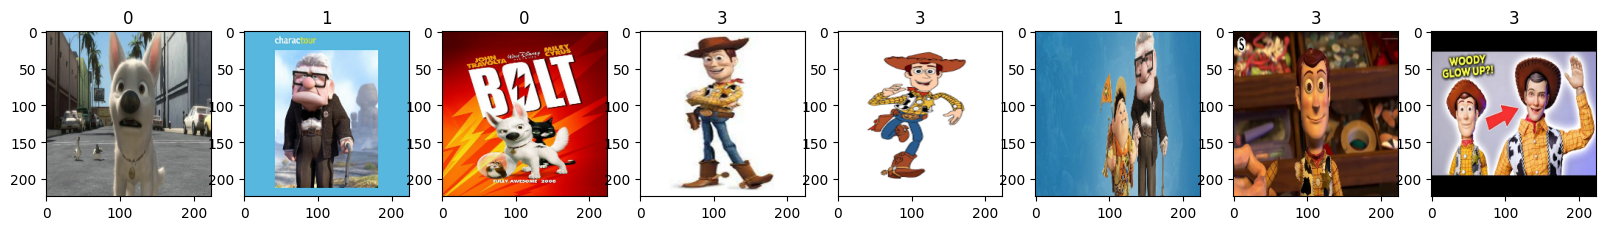

In [8]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [9]:
data = data.map(lambda x, y: (x/255.0, y))
print("Data type after normalization: {}".format(data.element_spec))
print("Data shape after normalization: {}".format(data.element_spec))
print("Jumlah data", len(data))


Data type after normalization: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Data shape after normalization: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Jumlah data 43


BAGI DATASET JADI 3 BAGIAN: TRAIN, VALIDASI, TESTING

In [10]:
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = int(0.1 * len(data))

print(train_size)
print(val_size)
print(test_size)

34
4
4


In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

MODEL VGGNet

In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [13]:
def residual_block(x, filters, downsample=False):
    strides = 1
    if downsample:
        strides = 2
        identity = Conv2D(filters, 1, strides=strides, padding='same')(x)
        identity = BatchNormalization()(identity)
    else:
        identity = x

    x = Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, identity])
    x = Activation('relu')(x)
    return x

In [14]:
def ResNet18(input_shape=(224, 224, 3), num_classes=1000):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)
    x = residual_block(x, 256, downsample=True)
    x = residual_block(x, 256)
    x = residual_block(x, 512, downsample=True)
    x = residual_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
model_resnet18 = ResNet18()
model_resnet18.compile(optimizer='adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_resnet18.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 64)         0         ['batch_normalization[0

In [16]:
history_resnet18 = model_resnet18.fit(train, validation_data=val, epochs=30)

Epoch 1/30


34/34 [==============================] - 149s 4s/step - loss: 2.3795 - accuracy: 0.3824 - val_loss: 3.5276 - val_accuracy: 0.2812
Epoch 2/30
34/34 [==============================] - 127s 4s/step - loss: 1.1071 - accuracy: 0.5331 - val_loss: 1.9954 - val_accuracy: 0.3438
Epoch 3/30
34/34 [==============================] - 129s 4s/step - loss: 0.9174 - accuracy: 0.6360 - val_loss: 1.9970 - val_accuracy: 0.3281
Epoch 4/30
34/34 [==============================] - 130s 4s/step - loss: 0.7733 - accuracy: 0.6949 - val_loss: 1.8126 - val_accuracy: 0.2500
Epoch 5/30
34/34 [==============================] - 130s 4s/step - loss: 0.6985 - accuracy: 0.7500 - val_loss: 1.9172 - val_accuracy: 0.3438
Epoch 6/30
34/34 [==============================] - 129s 4s/step - loss: 0.6325 - accuracy: 0.7665 - val_loss: 1.8400 - val_accuracy: 0.3125
Epoch 7/30
34/34 [==============================] - 131s 4s/step - loss: 0.5236 - accuracy: 0.8217 - val_loss: 1.5181 - val_accuracy: 0.4219
Epoch 8/30


In [17]:
import pandas as pd
#pip install openpyxl

# Convert the training history to a DataFrame
history_df = pd.DataFrame(history_resnet18.history)

# Save the DataFrame to an Excel file
history_df.to_excel('History_RESNET_B_SB 4.xlsx', index=False)

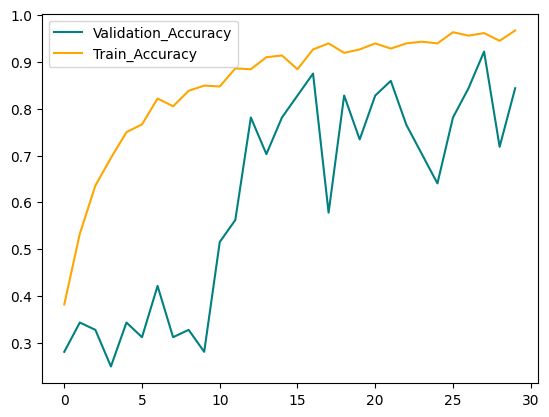

In [18]:
fig = plt.figure()
plt.plot(history_resnet18.history['val_accuracy'], color='teal', label='Validation_Accuracy')
plt.plot(history_resnet18.history['accuracy'], color='orange', label='Train_Accuracy')
plt.legend(loc="upper left")
plt.show()

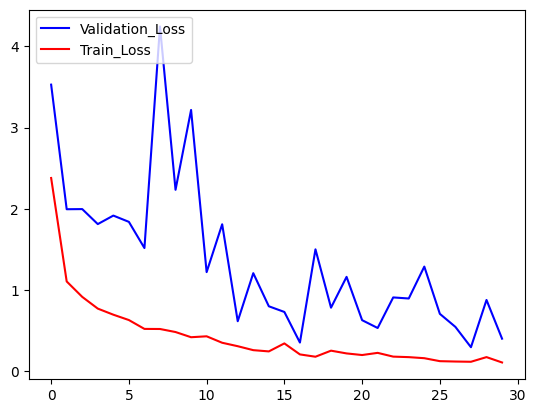

In [19]:
fig = plt.figure()
plt.plot(history_resnet18.history['val_loss'], color='blue', label='Validation_Loss')
plt.plot(history_resnet18.history['loss'], color='red', label='Train_Loss')
plt.legend(loc="upper left")
plt.show()

In [20]:
model_resnet18.evaluate(test)

4/4 [==============================] - 10s 818ms/step - loss: 0.3301 - accuracy: 0.8750


[0.3300582766532898, 0.875]

In [21]:
model_resnet18.save('model_resnet.h5')

c:\Program Files\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
